## FakeReal 2.0

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import tensorflow_hub as hub
import re
import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
#from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
#from googletrans import Translator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

In [4]:
import pandas as pd
newsu = pd.read_csv('newsu2.tsv').drop("Unnamed: 0", axis = 1)
newsu.head(3)
val = pd.read_csv("val_news2.tsv").drop("Unnamed: 0", axis = 1)

In [5]:
messages = newsu.copy()
messages.reset_index(inplace = True)

In [6]:
messages_test = val.copy()
messages_test.reset_index(inplace=True)

In [7]:
y = messages['rating']
X = messages.drop('rating', axis = 1)
# Creating a variable "merged" by merging columns "title" and "author"
X["merged"] = X["title"]+" "+X["author"]+X["text"]
X = X["merged"]

In [8]:
y_val = val['rating']
X_val = val.drop('rating', axis = 1)
X_val["merged"]  = X_val["text"]+" "+X_val["author"]+X_val["text"]
X_val = X_val["merged"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state = 0)

X_train = X_train.drop("index", axis =1)
X_test = X_test.drop("index", axis =1)
oe = OrdinalEncoder()
oe.fit(X_train)

X_train_enc = oe.transform(X_train)

#Find K-best features

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
kbest = SelectKBest(chi2, k=6).fit_transform(X_train_enc, y_train)
# Here we choose 6 so that is easier to analyze results later, as we will see
selected = pd.DataFrame(kbest)
#selected.head()

model = SelectKBest(chi2, k=6).fit(X_train_enc, y_train)
df = pd.DataFrame(data = model.scores_, columns = ['score'])
df['Column'] = X_train.columns
print(df.sort_values(by = ['score'], ascending = False).head(10))

df 

In [10]:
print(f' X_train: {X_train.shape}')
print(f' y_train: {y_train.shape}')
print(f' X_test: {X_test.shape}')
print(f' y_test: {y_test.shape}')

 X_train: (7310,)
 y_train: (7310,)
 X_test: (3601,)
 y_test: (3601,)


In [11]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [12]:
pip_count_nb = Pipeline([('vec', CountVectorizer()), ('clf_multi_nb', MultinomialNB(alpha = 0.001))])
pip_count_svm = Pipeline([('vec', CountVectorizer()), ('clf_svm_linear', LinearSVC(C = 0.5, max_iter = 100000))])
pip_tfidf_nb = Pipeline([('tfidf', TfidfVectorizer()), ('clf_multi_nb', MultinomialNB(alpha = 0.001))])
pip_tfidf_svm = Pipeline([('tfidf', TfidfVectorizer()), ('clf_svm_linear', LinearSVC(C = 3.0))])

In [13]:
#------------Best parameters alpha for MultinomialNB------------#

param_grid = {'clf_multi_nb__alpha': [0.001, 0.01, 0.1]}
param_grid = {'clf_multi_nb__alpha': [0.001, 0.01, 0.1]}

grid = GridSearchCV(pip_count_nb, param_grid)
grid = GridSearchCV(pip_tfidf_nb, param_grid)

grid.fit(X_train.values, y_train)

print(grid.best_score_)
print(grid.best_estimator_)

0.9270861833105336
Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf_multi_nb', MultinomialNB(alpha=0.1))])


In [14]:
#------------Best parameters C for LinearSVC------------#

param_grid = {'clf_svm_linear__C': [0.5, 1.0, 1.5]}
param_grid = {'clf_svm_linear__C': [1.5, 2.5, 3.0, 3.5]}

grid = GridSearchCV(pip_count_svm, param_grid)
grid = GridSearchCV(pip_tfidf_svm, param_grid)

grid.fit(X_train.values, y_train)

print(grid.best_score_)
print(grid.best_estimator_)

0.9718194254445965
Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf_svm_linear', LinearSVC(C=3.5))])


              precision    recall  f1-score   support

        Real       0.92      0.93      0.93      1766
        Fake       0.93      0.92      0.93      1835

    accuracy                           0.93      3601
   macro avg       0.93      0.93      0.93      3601
weighted avg       0.93      0.93      0.93      3601



C:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


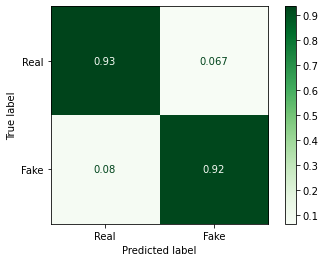

In [15]:
#Pipelines
# Dict for comparison of accuracy
accuracy = {}
#CountVectorizer and multinomialNB
pip_count_nb.fit(X_train.values, y_train)
y_pred_count_nb = pip_count_nb.predict(X_test.values)

# Classification report
print(classification_report(y_test, y_pred_count_nb, target_names = ['Real', 'Fake']))

# Confusion matrix
plot_confusion_matrix(pip_count_nb, X_test.values, y_test, display_labels = ['Real', 'Fake'],
                      normalize = 'true', cmap=plt.cm.Greens);
# Score
accuracy['countVectorizer_multinomialNB'] = accuracy_score(y_pred_count_nb, y_test)

              precision    recall  f1-score   support

        real       0.97      0.97      0.97      1766
        fake       0.97      0.97      0.97      1835

    accuracy                           0.97      3601
   macro avg       0.97      0.97      0.97      3601
weighted avg       0.97      0.97      0.97      3601



C:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


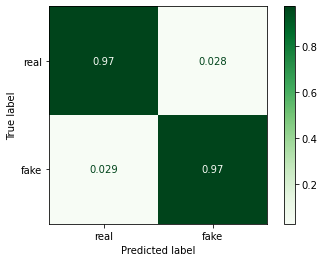

In [20]:
#CountVectorizer and linearSVC
pip_count_svm.fit(X_train.values, y_train)
y_pred_count_svm = pip_count_svm.predict(X_test.values)

# Classification report
print(classification_report(y_test, y_pred_count_svm, target_names = ['real', 'fake']))
# Confusion matrix
plot_confusion_matrix(pip_count_svm, X_test.values, y_test, display_labels = ['real', 'fake'], 
                      normalize = 'true', cmap=plt.cm.Greens);
# Score
accuracy['countVectorizer_linearSVC'] = accuracy_score(y_pred_count_svm, y_test)

In [18]:
validation = pip_count_svm.predict(X_val.values)

              precision    recall  f1-score   support

        Real       0.97      0.92      0.94       515
        Fake       0.92      0.97      0.94       485

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



C:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


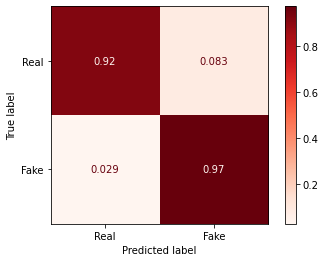

In [21]:
# Classification report
print(classification_report(y_val, validation, target_names = ['Real', 'Fake']))
# Confusion matrix
plot_confusion_matrix(pip_count_svm, X_val.values, y_val, display_labels = ['Real', 'Fake'], 
                      normalize = 'true', cmap=plt.cm.Reds);

              precision    recall  f1-score   support

        real       0.91      0.92      0.92      1766
        fake       0.92      0.91      0.92      1835

    accuracy                           0.92      3601
   macro avg       0.92      0.92      0.92      3601
weighted avg       0.92      0.92      0.92      3601



C:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


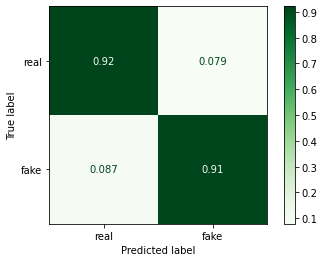

In [316]:
#TfidfVectorizer e multinomialNB
pip_tfidf_nb.fit(X_train.values, y_train)
y_pred_tfidf_nb = pip_tfidf_nb.predict(X_test.values)

# Classification report
print(classification_report(y_test, y_pred_tfidf_nb, target_names = ['real', 'fake']))
# Confusion matrix
plot_confusion_matrix(pip_tfidf_nb, X_test.values, y_test, display_labels = ['real', 'fake'], 
                      normalize = 'true', cmap=plt.cm.Greens);
# Score
accuracy['tfidfVectorizer_multinomialNB'] = accuracy_score(y_pred_tfidf_nb, y_test)

              precision    recall  f1-score   support

        Real       0.97      0.97      0.97      1766
        Fake       0.98      0.97      0.97      1835

    accuracy                           0.97      3601
   macro avg       0.97      0.97      0.97      3601
weighted avg       0.97      0.97      0.97      3601



C:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


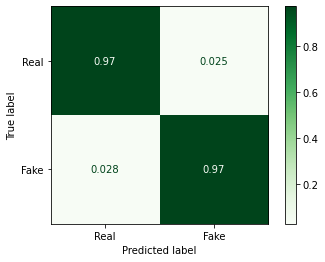

In [24]:
#TfidfVectorizer e linearSVC
pip_tfidf_svm.fit(X_train.values, y_train)
y_pred_tfidf_svm = pip_tfidf_svm.predict(X_test.values)
# Classification report
print(classification_report(y_test, y_pred_tfidf_svm, target_names = ['Real', 'Fake']))
# Confusion matrix
plot_confusion_matrix(pip_tfidf_svm, X_test.values, y_test, display_labels = ['Real', 'Fake'], 
                      normalize = 'true', cmap=plt.cm.Greens);
# Score
accuracy['tfidfVectorizer_linearSVC'] = accuracy_score(y_pred_tfidf_svm, y_test)



# Validation 1

In [25]:
validation = pip_tfidf_svm.predict(X_val.values)

              precision    recall  f1-score   support

        Real       0.97      0.94      0.96       515
        Fake       0.94      0.97      0.96       485

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



C:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


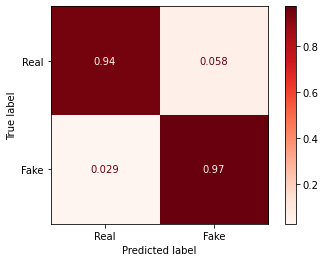

In [26]:
# Classification report
print(classification_report(y_val, validation, target_names = ['Real', 'Fake']))
# Confusion matrix
plot_confusion_matrix(pip_tfidf_svm, X_val.values, y_val, display_labels = ['Real', 'Fake'], 
                      normalize = 'true', cmap=plt.cm.Reds);

# More models

In [320]:
bag = []
for i in range(0, len(messages)):
    bag.append(messages['text'][i])

In [321]:
cv = CountVectorizer(max_features = 5000,ngram_range=(1,3))
X = cv.fit_transform(bag).toarray()
X.shape #(18285, 5000)
y =messages['rating']

In [322]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33,random_state = 0)
cv.get_feature_names()[:20]

C:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abaix',
 'abaix clic',
 'abandon',
 'abastec',
 'abat',
 'abenço',
 'abert',
 'abertur',
 'abin',
 'abord',
 'abordag',
 'abort',
 'abrac',
 'abrah',
 'abrah weintraub',
 'abrig',
 'abril',
 'abril ano',
 'abril de',
 'abril de de']

In [323]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [324]:
count_df = pd.DataFrame(X_train,columns = cv.get_feature_names())
#count_df.head()

In [325]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Multinomial Naive Bayes Algorithm

Accuracy: 0.876
Confusion matrix, without normalization


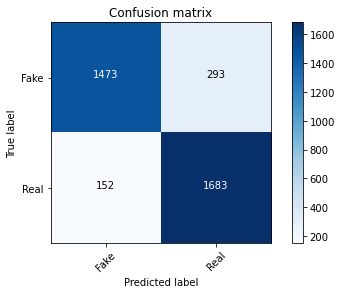

In [326]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
from sklearn import metrics
import numpy as np
import itertools
classifier1 = classifier.fit(X_train,y_train)
pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test,pred)
print("Accuracy: %0.3f"%score)
cm = metrics.confusion_matrix(y_test,pred)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [327]:
unique, counts = np.unique(pred, return_counts=True)
dict(zip(unique, counts))

{0.0: 1625, 1.0: 1976}

# Validation 2

Accuracy: 0.872
Confusion matrix, without normalization


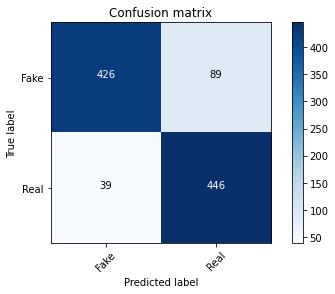

In [328]:
X_val_t = cv.transform(X_val).toarray()
pred1 = classifier.predict(X_val_t)
score = metrics.accuracy_score(y_val,pred1)
print("Accuracy: %0.3f"%score)
cm = metrics.confusion_matrix(y_val,pred1)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## Passive Aggressive Classifier Algorithm

Accuracy: 0.916
Confusion matrix, without normalization


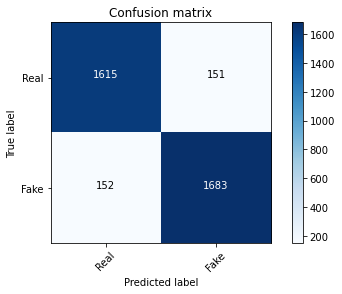

In [329]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=30)
linear_clf.fit(X_train,y_train)
pred = linear_clf.predict(X_test)
score = metrics.accuracy_score(y_test,pred)
print("Accuracy: %0.3f"%score)
cm = metrics.confusion_matrix(y_test,pred)
plot_confusion_matrix(cm,classes = ['Real','Fake'])

In [330]:
unique, counts = np.unique(pred, return_counts=True)
dict(zip(unique, counts))

{0.0: 1767, 1.0: 1834}

# Validation 3

Accuracy: 0.913
Confusion matrix, without normalization


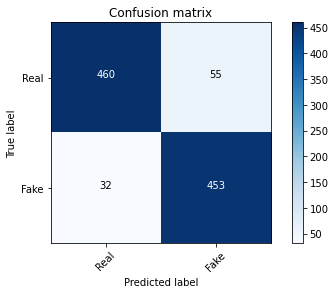

In [331]:
pred2 = linear_clf.predict(X_val_t)
score = metrics.accuracy_score(y_val,pred2)
print("Accuracy: %0.3f"%score)
cm = metrics.confusion_matrix(y_val,pred2)
plot_confusion_matrix(cm,classes = ['Real','Fake'])

## BERT Imbau 

In [332]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.decomposition import PCA
#import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix

In [333]:
from transformers import AutoModel, AutoTokenizer

# Using the community model
# BERT Base
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
bert = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [334]:
newsu['label']=pd.get_dummies(newsu.rating)[0.0]

In [335]:
train_text, temp_text, train_labels, temp_labels = train_test_split(newsu['text'], newsu['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=newsu['rating'])

In [336]:
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [337]:
MAX_LENGHT = 15
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

C:\Users\franc\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [338]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [339]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [340]:
for param in bert.parameters():
    param.requires_grad = False

In [341]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [342]:
model = BERT_Arch(bert)

In [343]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

C:\Users\franc\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [344]:
from sklearn.utils.class_weight import compute_class_weight

In [345]:
#compute the class weights
class_weights = compute_class_weight('balanced', classes = np.unique(train_labels), y = train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.99777894 1.00223097]


In [346]:
weights= torch.tensor(class_weights,dtype=torch.float)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [347]:
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    #print(type(labels),type(mask),type(sent_id))
    #print(sent_id)
    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [348]:
def evaluate():
  
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
      
        # Calculate elapsed time in minutes.
        #elapsed = format_time(time.time() - t0)
            
        # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
            batch = [t for t in batch]

            sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
        # model predictions
        preds = model(sent_id, mask)

        # compute the validation loss between actual and predicted values
        loss = cross_entropy(preds,labels)

        total_loss = total_loss + loss.item()

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [349]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    239.
  Batch   100  of    239.
  Batch   150  of    239.
  Batch   200  of    239.

Evaluating...
  Batch    50  of     52.

Training Loss: 0.003
Validation Loss: 0.014

 Epoch 2 / 10
  Batch    50  of    239.
  Batch   100  of    239.
  Batch   150  of    239.
  Batch   200  of    239.

Evaluating...
  Batch    50  of     52.

Training Loss: 0.003
Validation Loss: 0.014

 Epoch 3 / 10
  Batch    50  of    239.
  Batch   100  of    239.
  Batch   150  of    239.
  Batch   200  of    239.

Evaluating...
  Batch    50  of     52.

Training Loss: 0.003
Validation Loss: 0.014

 Epoch 4 / 10
  Batch    50  of    239.
  Batch   100  of    239.
  Batch   150  of    239.
  Batch   200  of    239.

Evaluating...
  Batch    50  of     52.

Training Loss: 0.003
Validation Loss: 0.014

 Epoch 5 / 10
  Batch    50  of    239.
  Batch   100  of    239.
  Batch   150  of    239.
  Batch   200  of    239.

Evaluating...
  Batch    50  of     52.

Training Loss: 0.00

In [350]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [351]:
with torch.no_grad():
    preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()

In [352]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       821
           1       0.00      0.00      0.00       816

    accuracy                           0.50      1637
   macro avg       0.25      0.50      0.33      1637
weighted avg       0.25      0.50      0.34      1637



C:\Users\franc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\franc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\franc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [353]:
from sklearn.metrics import confusion_matrix

In [354]:
conf = confusion_matrix(preds,test_y)
plot_confusion_matrix(conf, classes = ['Fake','Real'])

C:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


TypeError: plot_confusion_matrix() got an unexpected keyword argument 'classes'